# **1. Introduction**

Nama: Aldiandya Irsyad  
Batch: 8

Instagram adalah sebuah sosial media dimana user dapat membagikan foto dan video. Popularitas instagram sangat pesat berkembang semenjak dari mulai dibuat pada oktober 2010. Dalam instagram user dapat membagikan foto secara bebas mulai dari foto mereka, teman mereka, meme, pemandangan, dan masih banyak lainnya. Hal ini tentunya dapat meningkatkan kesulitan untuk menentukan siapa yang memposting gambar ataupun video tersebut. 

Dalam notebook ini saya akan menggunakan dataset yang saya dapatkan dengan GraphQL API instagram. Dataset ini berisi meta-data, thumbnail video/foto, dan captions dari lima orang terpopuler yang memiliki nama depan Justin berdasarkan ranker.com. Dataset tersebut didapatkan secara otomatis menggunakan sebuah script Python. Dalam notebook ini saya hanya menggunakan gambar thumbnail untuk memprediksi Justin mana yang membuat postingan tersebut.

Objective dalam notebook ini berguna untuk menguji apakah Deep Learning dapat klasifikasikan suatu hal yang bervariasi dan kompleks. Menurut saya, Deep Learning dapat mempelajari pola, namun dalam bagian ini kita ingin mencoba apakah deep learning dapat mempelajari beberapa pola dalam 1 klasifikasi. Pada kasus ini saya tidak ekspektasi akurasi yang cukup tinggi, bahkan dengan akurasi 35% merupakan akurasi yang cukup bagus dan kemungkinan dapat membuktikan bahwa deep learning dapat mempelajari permasalahan kompleks

# **2. Libraries & Config**

In [1]:
# builtin libraries
import warnings
from importlib import reload
import pickle
import cv2
import PIL.Image
import os

# utilities
from IPython.display import Image, Video
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
# Data Structures
import numpy as np
import pandas as pd


# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pandas_profiling

# Algorithms
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Configuration
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.4f}'.format


%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')
colors = sns.color_palette()

random_state = 231019
sk.set_config(display="diagram")
tf.random.set_seed(random_state)
np.random.seed(random_state)


# **3. Data Loading**

**Read dataset**

In [2]:
df = pd.read_csv('prebalanced_dataset.csv')
df.head()

Unnamed: 0          username                                     urls  \
0        6960  justintimberlake  https://www.instagram.com/p/CTYCdJ8FBWv   
1        6961  justintimberlake  https://www.instagram.com/p/CTFzRPVg6W9   
2        6962  justintimberlake  https://www.instagram.com/p/CSh-TDQgOp_   
3        6963  justintimberlake  https://www.instagram.com/p/CSP9RQHrwbV   
4        6964  justintimberlake  https://www.instagram.com/p/CSKJo6Cr7qP   

   post_dates display_picture_relative_url  \
0  1630706711       ./imgs/CTYCdJ8FBWv.png   
1  1630094797       ./imgs/CTFzRPVg6W9.png   
2  1628892631       ./imgs/CSh-TDQgOp_.png   
3  1628288073       ./imgs/CSP9RQHrwbV.png   
4  1628093232       ./imgs/CSKJo6Cr7qP.png   

                                            captions  n_likes  n_comments  \
0                            In no particular order.   235255        2031   
1                                        Still hits.   403619        4019   
2                                    Getting closer…    56882        1213   
3  My heart is so heavy. We lost a beautiful soul...   411930        7619   
4                  Is everyone else’s this accurate?   501585        3883   

   n_hashtags  n_characters  n_words  n_emojis  n_mentions  is_video  
0           0            23        4         0           2     False  
1           0            11        2         0           6      True  
2           0            15        2         0           1      True  
3           0           594      120         1           7     False  
4           0            33        5         0           0     False

**Filter Dataset**

In [3]:
df = df[['username', 'display_picture_relative_url']].copy()

**Create `original_width` and `original_height` columns**

In [4]:
widths = []
heights = []
dpis = []
for path in df['display_picture_relative_url']:
    img = PIL.Image.open(f'{path}')
    widths.append(img.width)
    heights.append(img.height)
    img.close()
df['original_width'] = widths 
df['original_height'] = heights

**Resize and Crop Image to 224x224**

In [5]:
def preproces_image(img):
    width, height = img.size
    if width > height:
        left = (width - height) // 2
        right = width - left
        img = img.crop((left, 0, right, height))
    elif height > width:
        total_cropped = height - width 
        top = total_cropped * (30/100)
        bottom = top + width

        img = img.crop((0, top, width, bottom))
    
    # resize to 224x224
    return img.resize((224, 224), PIL.Image.ANTIALIAS)

def preprocess_training_imgs(output_directory, df, url='display_picture_relative_url', target='username'):
    if not os.path.exists(output_directory): 
        os.makedirs(output_directory)

    url_train, url_test, label_train, label_test = train_test_split(df[url], df[target], test_size=0.2, random_state=random_state, stratify=df[target])

    new_paths = []
    # handle train data
    for path, label in zip(url_train, label_train):
        output_path = f"{output_directory}/train/{label}/{path.split('/')[-1]}"


        # skip if file exists
        new_paths = new_paths + [output_path]

        if os.path.exists(output_path): continue
        # create directory if label file don't exist
        if not os.path.exists(f"{output_directory}/train/{label}/"):
            os.makedirs(f"{output_directory}/train/{label}/")


        img = PIL.Image.open(path)
        img = preproces_image(img)
        img.save(output_path, "JPEG", quality=75, compress_level=9, progressive=True)

    for path, label in zip(url_test, label_test):
        output_path = f"{output_directory}/test/{label}/{path.split('/')[-1]}"


        # skip if file exists
        new_paths = new_paths + [output_path]
        if os.path.exists(output_path): continue
        # create directory if label file don't exist
        if not os.path.exists(f"{output_directory}/test/{label}/"):
            os.makedirs(f"{output_directory}/test/{label}/")


        img = PIL.Image.open(path)
        img = preproces_image(img)
        img.save(output_path, "JPEG", quality=75, compress_level=9, progressive=True)

    return new_paths

In [17]:
df['preprocessed_url'] = preprocess_training_imgs('./processed_imgs', df)

**Recap**
1. Kita membaca dataset.
2. Filter kolumn yang tidak digunakan (NLP/Tabular).
3. Buat kolom baru untuk informasi gambar.
4. Resize gambar jadi 224x224.

# **4. Exploratory Data Analysis (EDA)**

## A. Jumlah Label

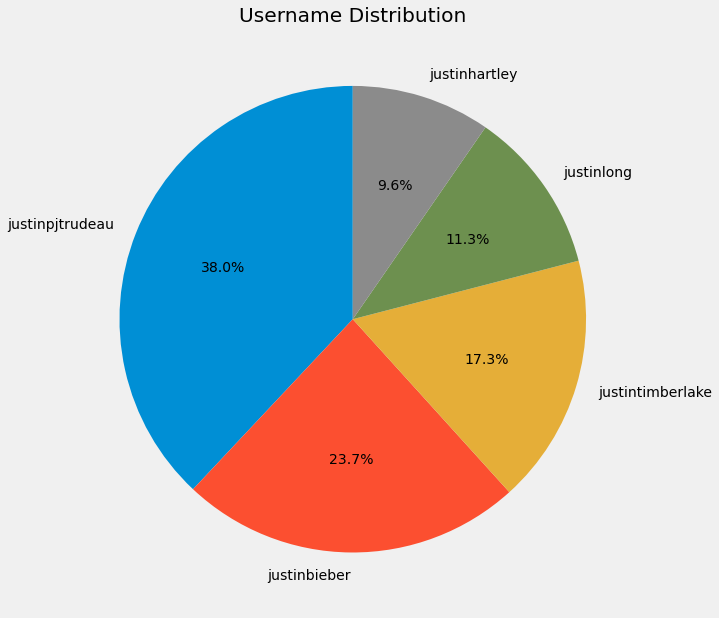

In [18]:
# plot username in piechart with percentage
plt.figure(figsize=(10, 10))
plt.pie(df['username'].value_counts(), labels=df['username'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Username Distribution')
plt.show()

Data tersebut sangat imbalanc dengan data `justinpjtrudeau` memiliki data lebih dari empat kali `justinhartley`.  
Kita juga dapat melihat data tersebut dengan bar plot

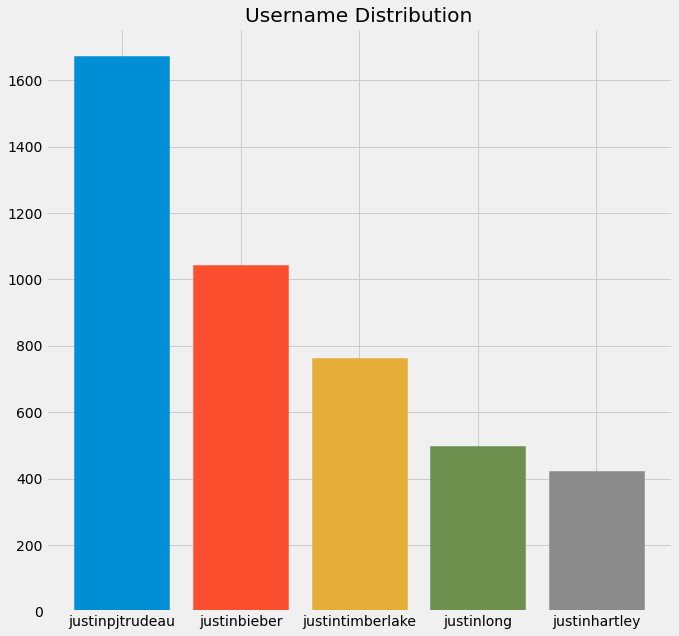

In [19]:
# bar plot of username
plt.figure(figsize=(10, 10))
barlist = plt.bar(df['username'].value_counts().index, df['username'].value_counts())
for i, bar in enumerate(barlist):
    bar.set_color(colors[i])
plt.title('Username Distribution')
plt.show()


Jika kita menggunakan dataset tersebut akan diprediksi bahwa model kesempatan besar akan lebih bias terhadap justinpjtrudeau

## B. Resolution

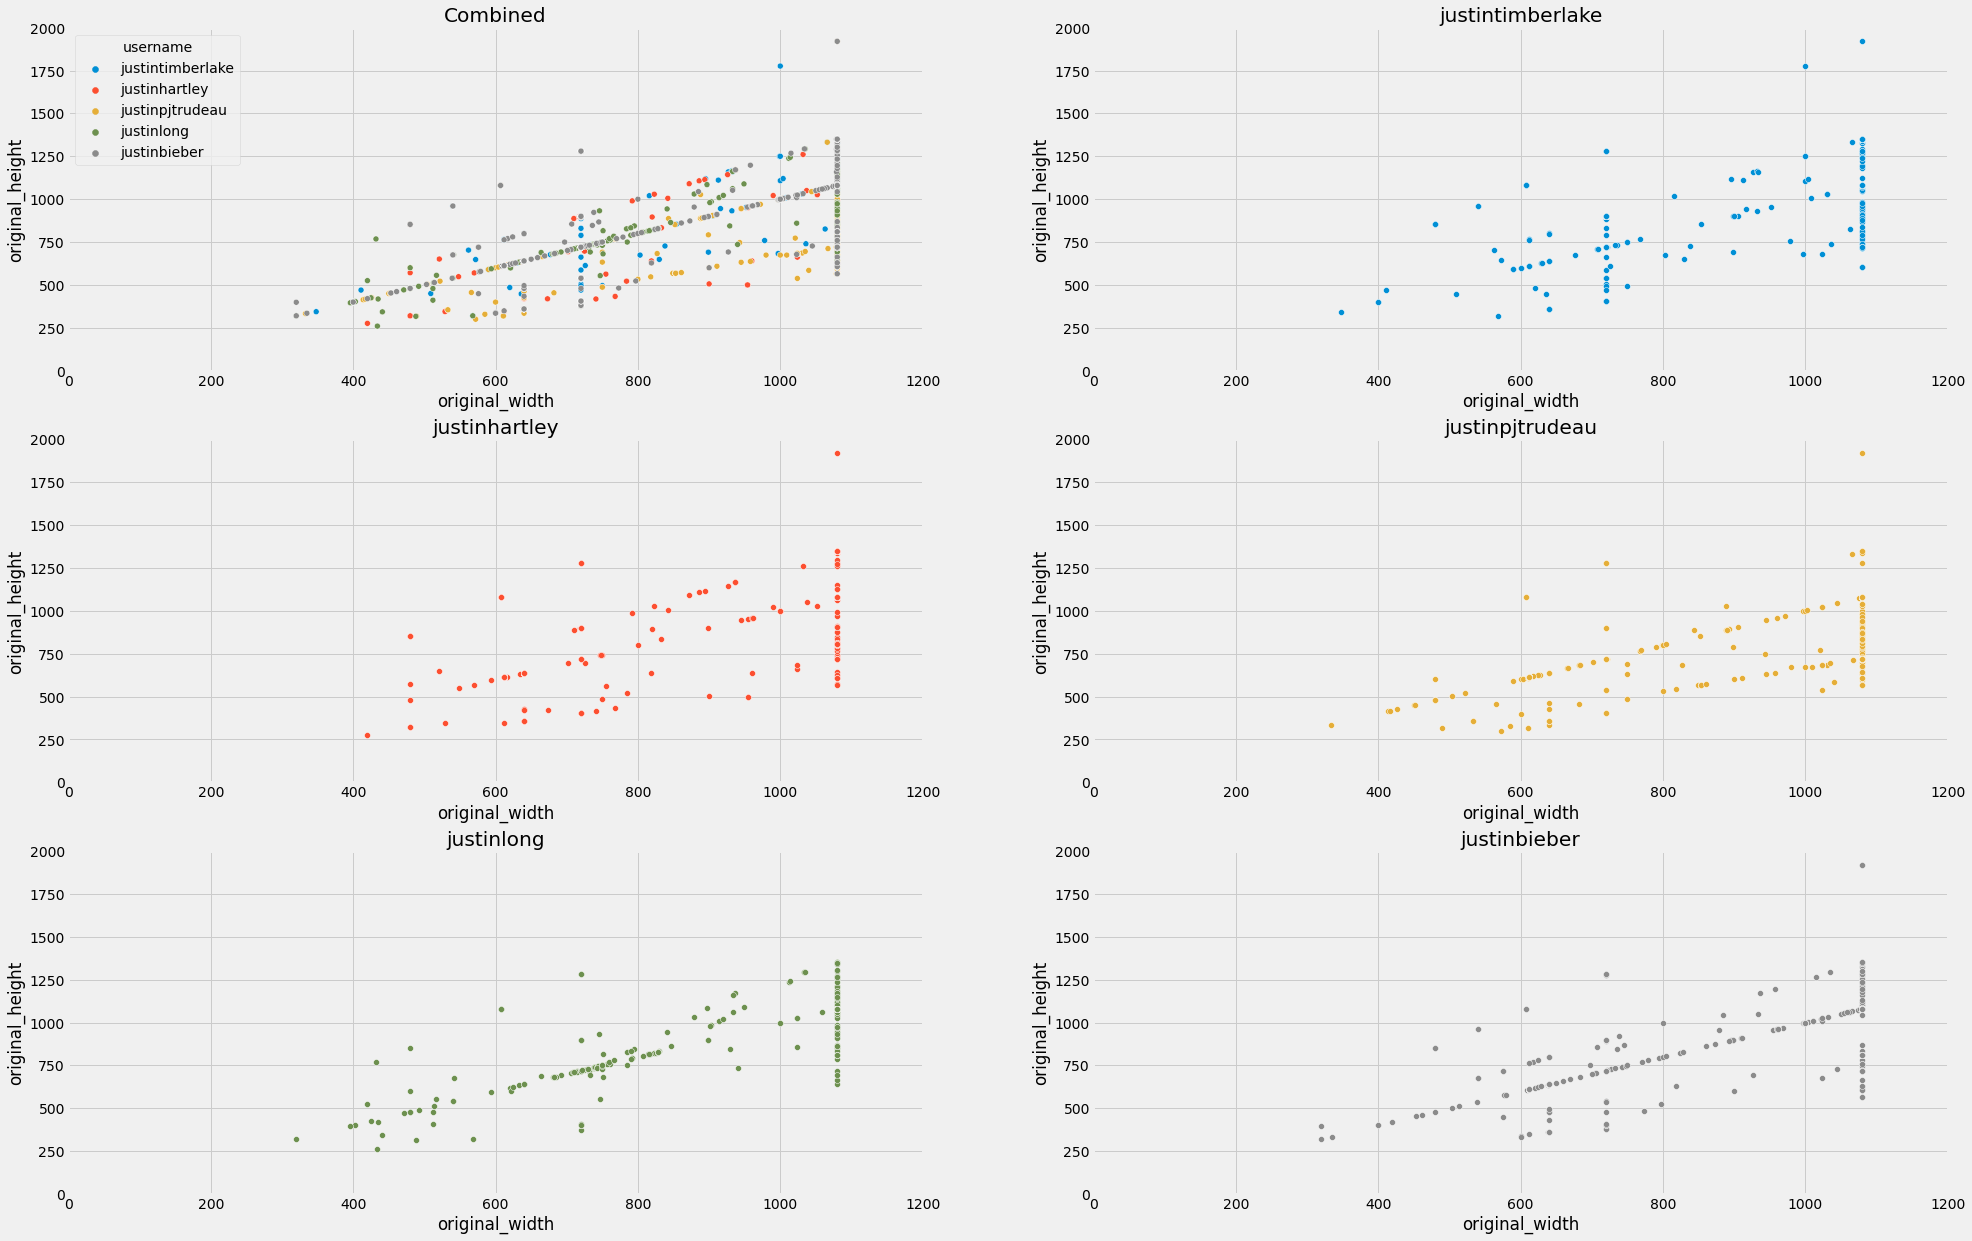

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(30, 20))

for i, ax in enumerate(axes.flatten()):
    ax.set_ylim(0, 2000)
    ax.set_xlim(0, 1200)

    if i == 0:
        ax.set_title('Combined')
        sns.scatterplot(x='original_width', y='original_height', data=df, ax=ax, hue='username')
    else:
        ax.set_title(df['username'].unique()[i - 1])
        sns.scatterplot(x='original_width', y='original_height', data=df[df['username'] == df['username'].unique()[i - 1]], ax=ax, color=colors[i - 1])

Berdasarkan kombinasi tersebut resolusi yang paling umum adalah 1:1, dan ternyata kita mengetahui bahwa `width` akan dilimitasi dengan nilai maksimum 1080

## C. Sample Image

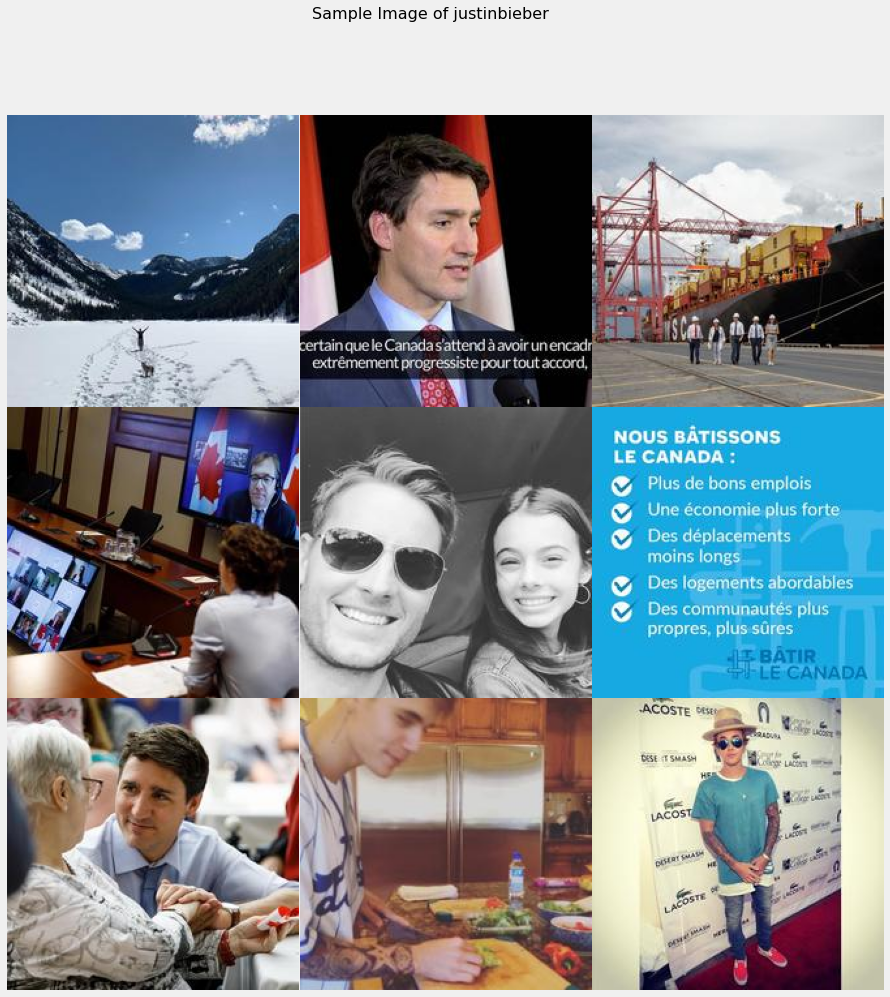

In [21]:
def show_sample_images(username):
    random_index = np.random.choice(df[df['username'] == username].index, size=9, replace=False)
    fig, axes = plt.subplots(3, 3, figsize=(14, 15))
    fig.suptitle(f'Sample Image of {username}', fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(PIL.Image.open(df['preprocessed_url'][random_index[i]]))
    
    plt.subplots_adjust(wspace=0, hspace=0)

show_sample_images('justinbieber')

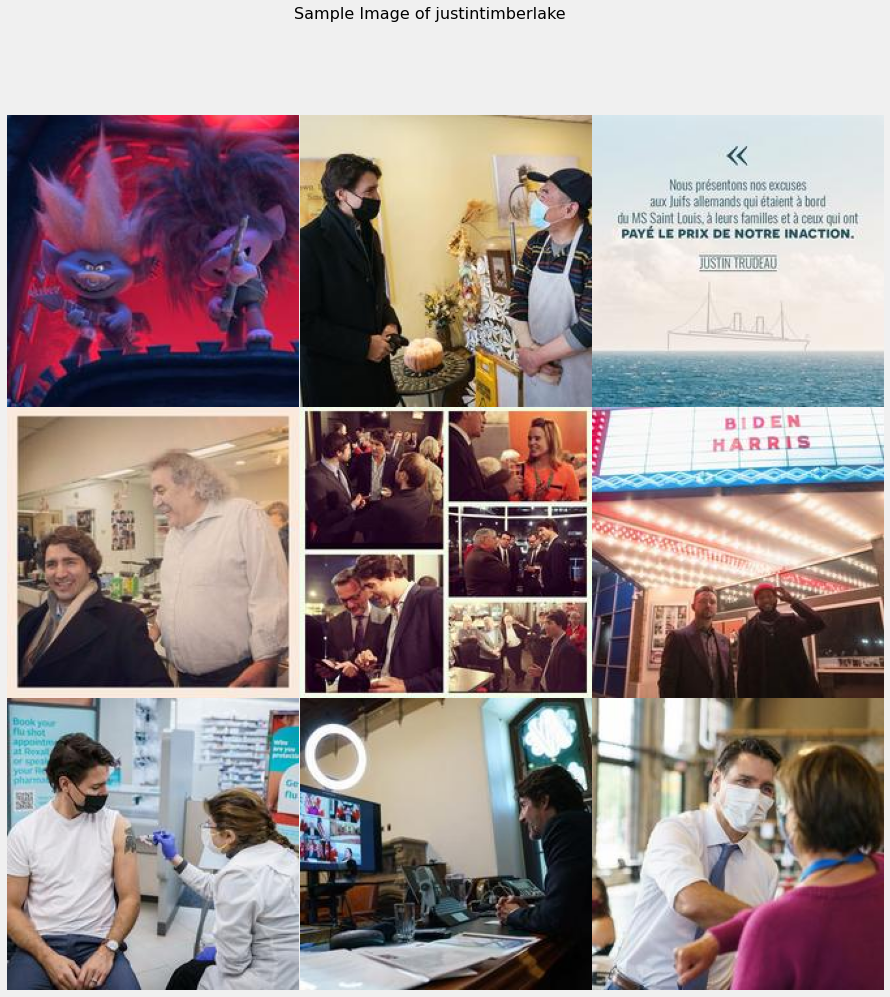

In [22]:
show_sample_images('justintimberlake')

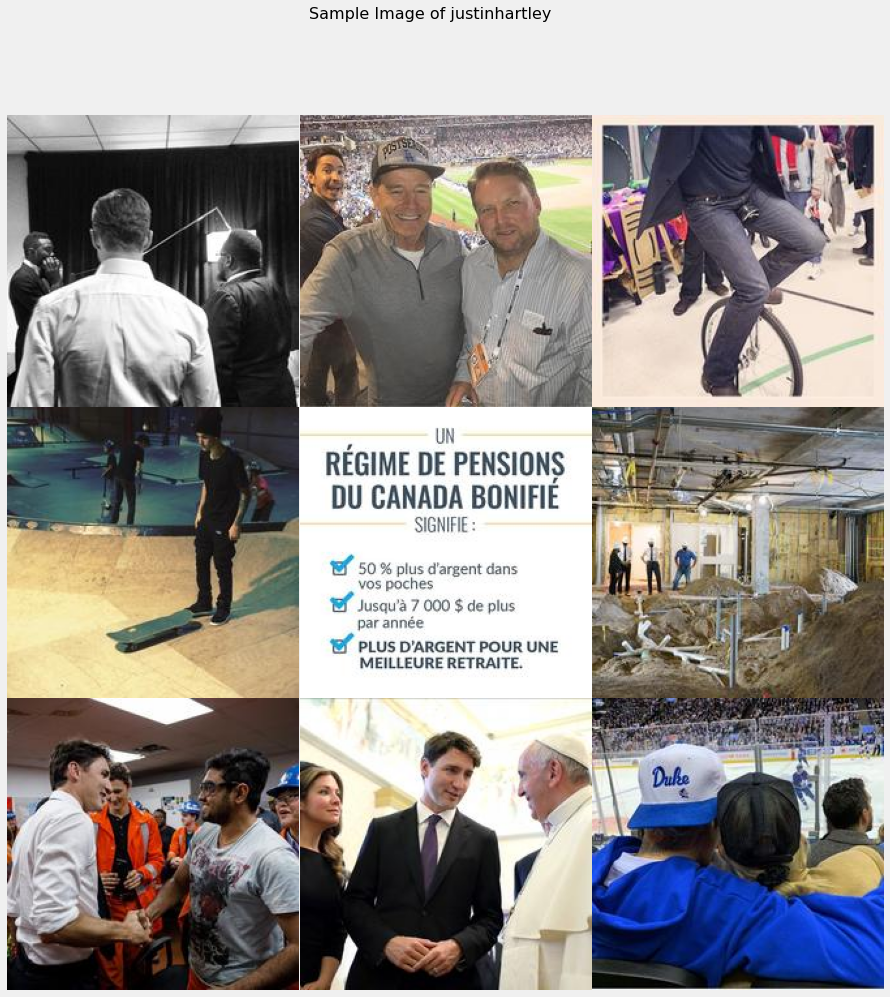

In [23]:
show_sample_images('justinhartley')

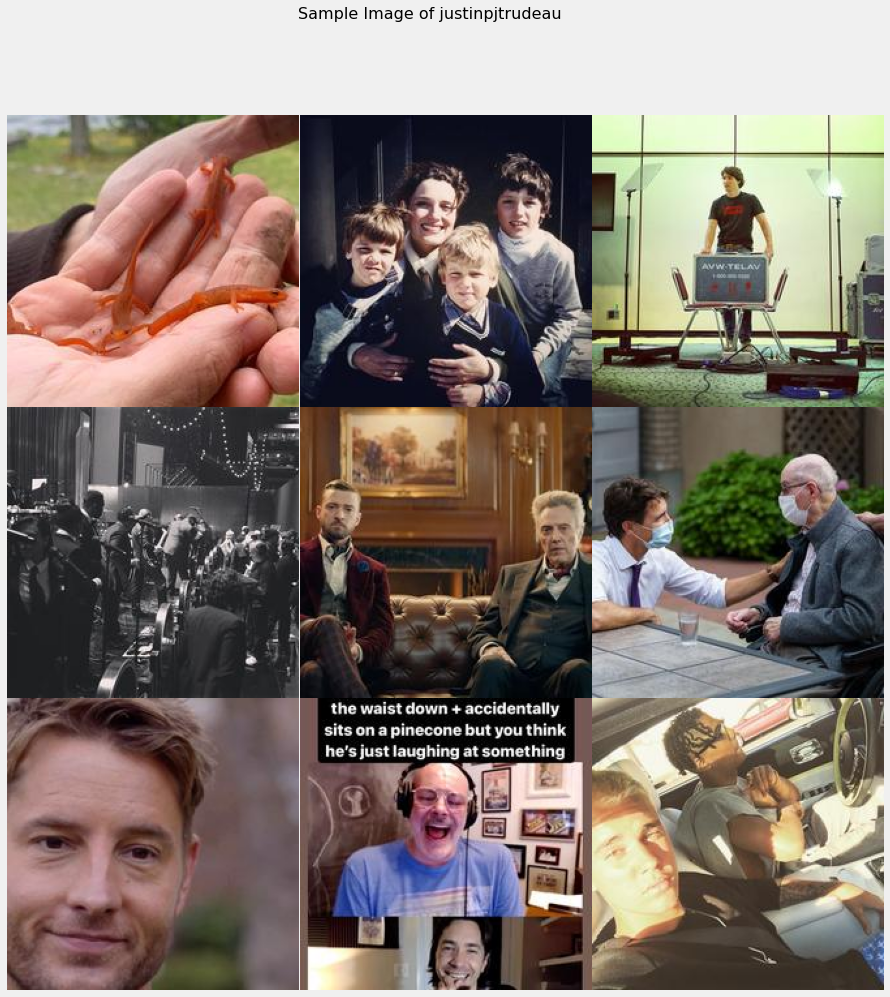

In [24]:
show_sample_images('justinpjtrudeau')


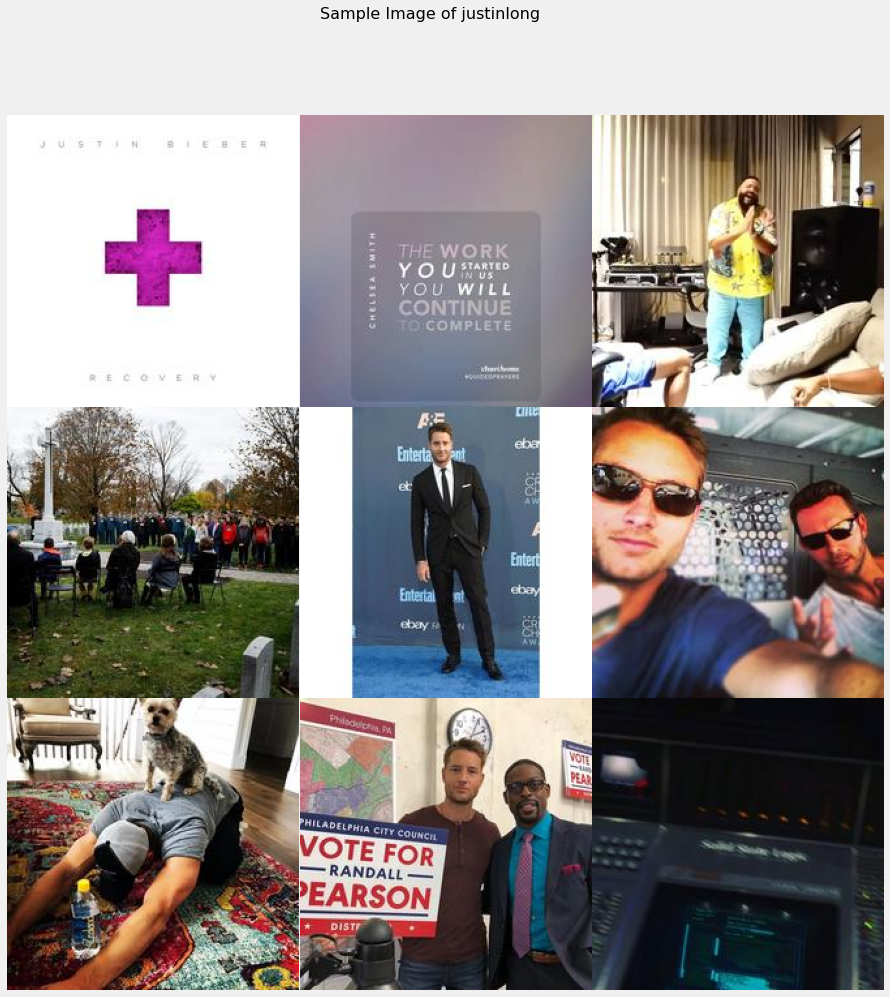

In [25]:
show_sample_images('justinlong')


Seperti pada latar belakang, instagram dapat mengizinkan user post apapun mulai dari pemandangan, dirinya dan lain lain. Hal ini akan membuat model kita sangat sulit untuk generalisir tanpa preprocessing yang benar.

## D. Colors Spectrum

In [26]:
def show_color_average(username, max_photo = 150):
    j = 0
    img_colors = np.zeros([224, 224, 3])
    for i, path in enumerate(df[df['username'] == username]['preprocessed_url']):
        img = PIL.Image.open(path)
        img_color = np.array(img)

        if i == 0: 
            img_colors += img_color
            continue 

        img_colors *= i/(i + 1)
        img_colors += img_color / (i + 1)


        
        j += 1
        if j >= max_photo:
            break
    
    return img_colors.astype(int)


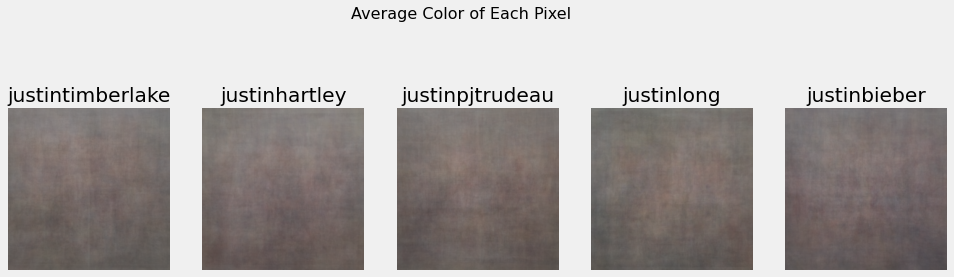

In [27]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Average Color of Each Pixel', fontsize=16)
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.set_title(df['username'].unique()[i])
    ax.imshow(show_color_average(df['username'].unique()[i]))

Secara kasat mata tidak terdapat banyak bias warna diantara seluruh post mereka

In [17]:
def slide_show_generator(username, max_photo = 150):
    j = 0
    img_colors = np.zeros([224, 224, 3])
    for i, path in enumerate(df[df['username'] == username]['preprocessed_url']):
        img = PIL.Image.open(path)
        img_color = np.array(img)

        if i == 0: 
            img_colors += img_color
            continue 

        img_colors *= i/(i + 1)
        img_colors += img_color / (i + 1)


        yield img_colors.astype(int)
        j += 1
        if j >= max_photo:
            return

# if slideshow folder doesn't exist
if not os.path.exists('./slideshow'):
    os.makedirs('./slideshow')

for name in df['username'].unique():
    
    for i, img in enumerate(slide_show_generator(name, max_photo=150)):

        img = PIL.Image.fromarray(np.uint8(img), 'RGB')
        img.save(f'./slideshow/{name}_{i}.jpg')


In [18]:
%%capture
# delete justinbieber.mp4 if file exist
if os.path.exists('./video/justinbieber.mp4'): os.remove('./video/justinbieber.mp4')
if os.path.exists('./video/justintimberlake.mp4'): os.remove('./video/justintimberlake.mp4')
if os.path.exists('./video/justinhartley.mp4'): os.remove('./video/justinhartley.mp4')
if os.path.exists('./video/justinpjtrudeau.mp4'): os.remove('./video/justinpjtrudeau.mp4')
if os.path.exists('./video/justinlong.mp4'): os.remove('./video/justinlong.mp4')

!ffmpeg -framerate 5 -f image2 -i "./slideshow/justinbieber_%d.jpg" "./video/justinbieber.mp4"
!ffmpeg -framerate 5 -f image2 -i "./slideshow/justintimberlake_%d.jpg" "./video/justintimberlake.mp4"
!ffmpeg -framerate 5 -f image2 -i "./slideshow/justinhartley_%d.jpg" "./video/justinhartley.mp4" 
!ffmpeg -framerate 5 -f image2 -i "./slideshow/justinpjtrudeau_%d.jpg" "./video/justinpjtrudeau.mp4" 
!ffmpeg -framerate 5 -f image2 -i "./slideshow/justinlong_%d.jpg" "./video/justinlong.mp4" 

**Show Slide (not working on github)**
<div style="display:flex;">
    <div><video alt="test" autoplay controls src="./video/justinbieber.mp4" type="video/mp4"/></div>
    <div><video alt="test" autoplay controls src="./video/justintimberlake.mp4" type="video/mp4"/></div>
    <div><video alt="test" autoplay controls src="./video/justinhartley.mp4" type="video/mp4"/></div>
    <div><video alt="test" autoplay controls src="./video/justinpjtrudeau.mp4" type="video/mp4"/></div>
    <div><video alt="test" autoplay controls src="./video/justinlong.mp4" type="video/mp4"/></div>
</div>


## E. Warna Dominan 

In [19]:
def show_number_of_dominan_color(username, max_photo = 150):
    j = 0
    R = 0
    G = 0
    B = 0
    for i, path in enumerate(df[df['username'] == username]['preprocessed_url']):
        img = PIL.Image.open(path)
        img_color = np.array(img)
        r, g, b = img_color.mean(axis=(0, 1))

        if r >= g and r >= b:
            R += 1
        if g >= r and g >= b:
            G += 1
        if b >= r and b >= g:
            B += 1

        
        j += 1
        if j >= max_photo:
            break
    
    return R, G, B

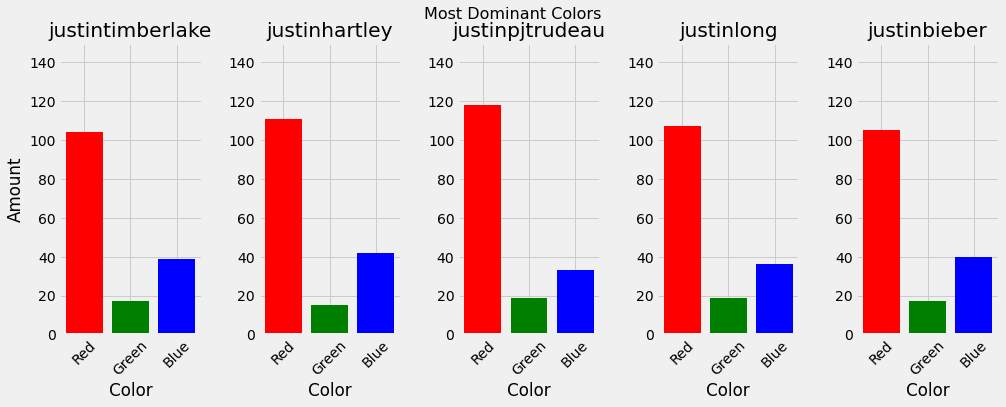

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
fig.suptitle('Most Dominant Colors', fontsize=16)
axes[0].set_ylabel('Amount')
for i, (ax, username) in enumerate(zip(axes.flatten(), usernames)):
    ax.axis('off')
    ax.set_title(username)
    R, G, B = show_number_of_dominan_color(username)
    # bar plot
    ax.bar(['Red', 'Green', 'Blue'], [R, G, B], color=['red', 'green', 'blue'])
    ax.set_xticklabels(['Red', 'Green', 'Blue'], rotation=45)
    ax.set_xlabel('Color')
    ax.axis('on')
    ax.set_ylim(0, 150)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)


Berdasarkan informasi ini, mereka memiliki distribusi yang hampir sama. Oleh karena itu kita dapat simpulkan bahwa kesempatan terdapat bias warna sangatlah kecil

# **5. Data Preprocessing**

Pada preprocessing kita akan memisah data menjadi 3 yaitu train, validation, dan test.

In [21]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [22]:
training_set = train_datagen.flow_from_directory(
    './processed_imgs/train',
    target_size=(224, 224),
    shuffle=True,
    batch_size=128,
    class_mode='categorical',
    seed=123,
    subset='training'
)

validation_set = train_datagen.flow_from_directory(
    './processed_imgs/train',
    target_size=(224, 224),
    shuffle=True,
    batch_size=128,
    class_mode='categorical',
    seed=123,
    subset='validation'
)




Found 2820 images belonging to 5 classes.
Found 702 images belonging to 5 classes.


In [23]:
testing_set = test_datagen.flow_from_directory(
    './processed_imgs/test',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    seed=123,
    subset='training'
)

Found 881 images belonging to 5 classes.


# **6. Model Definition**

Untuk model kita menggunakan `ResNet50V2` sebagai base model.

In [24]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
)

for layer in resnet.layers:
    layer.trainable = False

In [25]:
inputs = keras.Input(shape=(224, 224, 3))
x = resnet(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

base_model = keras.Model(inputs=inputs, outputs=outputs)

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# user earlystopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# select best model callback
model_checkpoint = keras.callbacks.ModelCheckpoint(
    './models/best_base_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

base_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [27]:
%%capture  
hist = base_model.fit(training_set,
                validation_data = validation_set,
                epochs = 20, callbacks=[early_stopping, model_checkpoint]
                )

# **7. Model Evaluation**

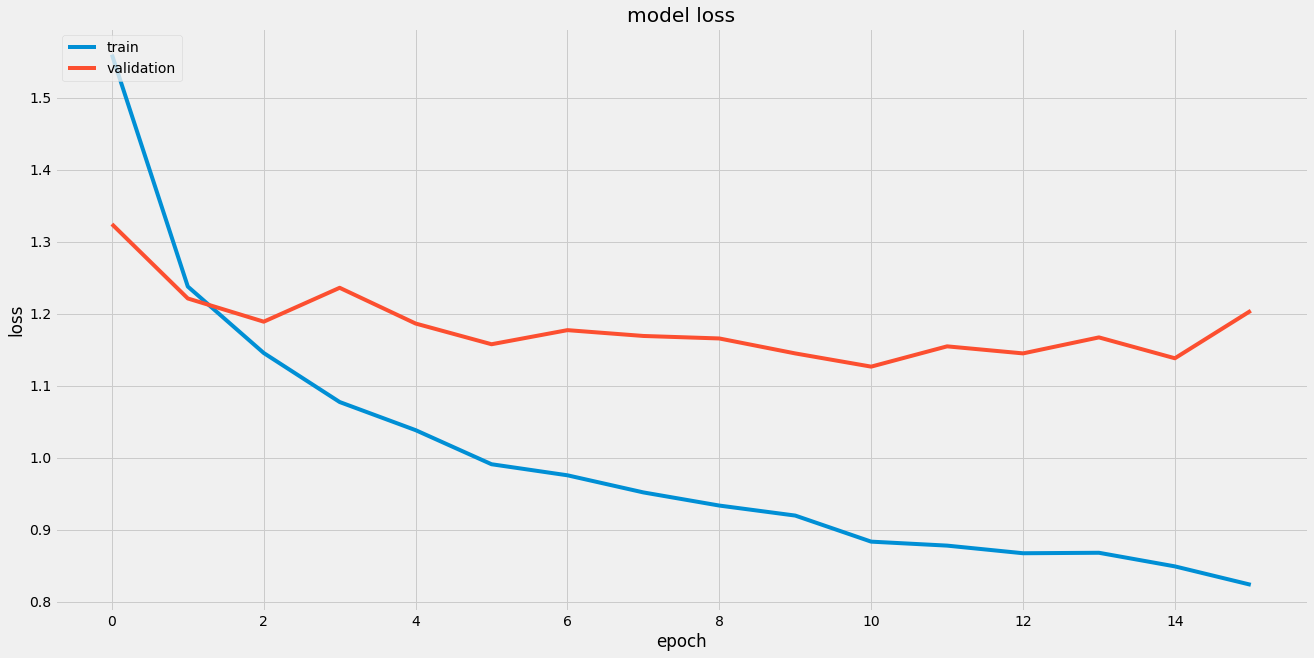

In [28]:
# plot hist loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Dari gambar tersebut kita dapat simpulkan model kita tidak dapat generalisir permasalahan. Hal ini ditandakan dengan `train` yang turun namun `val` yang tidak turun menurun

In [29]:
y_true = testing_set.classes
y_pred = base_model.predict(testing_set).argmax(axis=1)
classname = ['justinbieber', 'justintimberlake', 'justinhartley', 'justinpjtrudeau', 'justinlong']
print(classification_report(y_true, y_pred, target_names=classname))


                  precision    recall  f1-score   support

    justinbieber       0.26      0.23      0.25       209
justintimberlake       0.13      0.13      0.13        85
   justinhartley       0.10      0.11      0.10       100
 justinpjtrudeau       0.45      0.48      0.47       335
      justinlong       0.15      0.13      0.14       152

        accuracy                           0.29       881
       macro avg       0.22      0.22      0.22       881
    weighted avg       0.28      0.29      0.28       881



model kita memiliki akurasi `0.29` seperti yang diduga, model kita bias terhadap `justinpjtrudeau`

**Model Improvement**

In [50]:
inputs = keras.Input(shape=(224, 224, 3))
x = resnet(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)
improved_models = keras.Model(inputs=inputs, outputs=outputs)

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
improved_models.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    './models/best_tuned_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [52]:
%%capture
hist = improved_models.fit(training_set,
                validation_data = validation_set,
                epochs = 20, callbacks=[early_stopping, model_checkpoint])

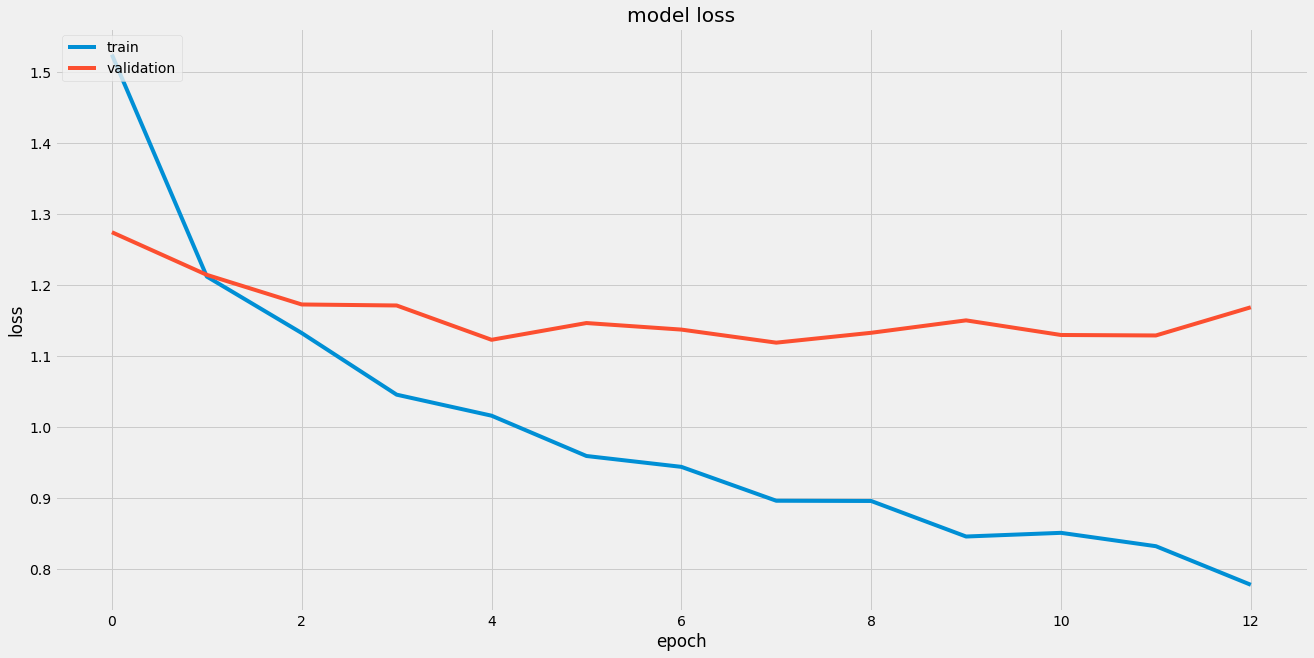

In [53]:
# plot hist loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [49]:
y_true = testing_set.classes
y_pred = improved_models.predict(testing_set).argmax(axis=1)
classname = ['justinbieber', 'justintimberlake', 'justinhartley', 'justinpjtrudeau', 'justinlong']
print(classification_report(y_true, y_pred, target_names=classname))


                  precision    recall  f1-score   support

    justinbieber       0.25      0.30      0.27       209
justintimberlake       0.14      0.08      0.10        85
   justinhartley       0.15      0.12      0.13       100
 justinpjtrudeau       0.37      0.42      0.39       335
      justinlong       0.16      0.12      0.14       152

        accuracy                           0.27       881
       macro avg       0.21      0.21      0.21       881
    weighted avg       0.26      0.27      0.26       881



Percobaan `model improvement` tersebut belum lah berhasil. Namun kita dapat melihat `justinpjtrudeau` memiliki precision yang lebih kecil dibanding model base kita dengan mengorbankan 2% akurasi.

**Model Evaluation Verdict**

Kedua model tersebut belum dapat mengeneralisir permasalahan. Hal ini menurut saya dikarenakan kurangnya data yang support untuk informasi se-kompleks ini. Sebagai contoh sebuah user dapat membuat beberapa kategori post seperti pemandangan, meme, foto dirinya, foto temannya dll. Perbedaan antara pemandangan dan meme sangatlah jauh, dan memungkinkan 1 user hanya post satu kali dari sebuah kategori. Hal ini tentunya membuat model tidak dapat generalisir antara sebuah post dalam sebuah kategori oleh user yang mana. 

Untuk membuat model yang dapat yang dapat menyelesaikan permasalahan ini sepertinya dibutuhkan:
1. Informasi kategorisasi.
2. Data yang lebih banyak per kategorisasi.
3. Informasi relationship user (teman/nama teman/foto teman)

Hal-hal tersebut membuat deep learning model tidak mendapatkan lingkup yang ideal. Diperlukan jauh lebih banyak data per-individu dan juga diperlukan preprocessing yang jauh lebih kompleks

# **8. Model Saving**

Model saving sudah dilakukan otomatis menggunakan fungsi callback.

# **9. Model Inference**

In [61]:
img = PIL.Image.open('./inferences/justinpjtrudeau.jpg')
img = preproces_image(img)
img = np.expand_dims(img, axis=0)

pred = improved_models.predict(img).argmax(axis=1)[0]
print(classname[pred])

justinpjtrudeau


# **10. Conclusion**

Model kita belum dapat meraih dari yang diinginkan, hanya lebih dari random guess (20%). Kenaikan menjadi 29% menurut saya bukan dikarenakan model belajar beberapa hal tersebut, namun dia hanya menentukan apakah foto tersebut meme, pemandangan, atau yang lainnya. Yang kemudian kategorisasi tersebut akan dibuat menjadi prediksi.

Dalam EDA kita juga mempelajari kemungkinan tersebut ketika kita melihat bahwa data sangat imbalance dengan sebuah label memiliki 4x data lebih banyak dari label terkecil. 

Sesuai dengan objective, saya belum dapat membuat deep learning yang dapat klasifikasi beberapa pola. Menurut saya permasalahan ini merupakan permasalahan yang menarik dikarenakan dari kompleksitas dan banyaknya permasalahan feeling terhadap permasalahan tersebut